<a href="https://colab.research.google.com/github/navneetkrc/Recommender_systems/blob/master/semantic%20search/Document_similarity_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
!pip install stop_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp27-none-any.whl size=32916 sha256=1887d6d3c276e0964d7d458f10c6b7d787e6d5072e374618739ff6c061f08ef5
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel, Word2Vec
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
import stop_words
from scipy.stats import wasserstein_distance
from pyemd import emd
from scipy.spatial.distance import cosine
sns.set_style("darkgrid")

### Data Import

In [0]:
filepath = "/content/drive/My Drive/MLAI_Datasets/Document similarity research/fake_Document_similarity_research.csv"
df = pd.read_csv(filepath, usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,69f7083afcc364378a76c5a67d1be7b1cf79e437,Robert Spencer,Selective Outrage Over SPLC’s 'Anti-Muslim Ext...,Search Selective Outrage Over SPLC’s 'Anti-Mus...,english,frontpagemag.com,US
1,cbd5f52e70642cb8c1a4dcb8bb91ad04865135c6,EdJenner,Artificial Intelligence System Predicts Trump ...,An artificial intelligence system that correct...,english,dailywire.com,US
2,97177f939b988cbef405337d86fb8eacd4e56999,NaN,Trump’s Thanksgiving Message From Three Years ...,Share on Facebook \nIf there’s one thing we as...,english,newcenturytimes.com,US
3,efaad85e548ac02bc35af465b023389a5461dfe6,Jerri-Lynn Scofield,Solution for Syria Requires United States to C...,by Jerri-Lynn Scofield \nJerri-Lynn here. Norm...,english,nakedcapitalism.com,US
4,8646c688ac4b2d7958fdea5acdc4ad1183f7f585,Starkman,Police Turn In Badges Rather Than Incite Viole...,At least two police officers turned in their b...,english,topinfopost.com,US


In [0]:
def initial_clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stop_words.get_stop_words('english')
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [0]:
# clean text and title and create new column "tokenized"
#%time
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

('Time to clean and tokenize', 12357, 'articles:', 4.468412085374196, 'min')


In [0]:
# first get a list of all words
all_words = [word for item in df['tokenized'].tolist() for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96283

In [0]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('dovethat', 1),
 (u'goalori', 1),
 (u'wardgetti', 1),
 (u'persion', 1),
 (u'daycaus', 1),
 (u'rainmak', 1),
 ('amazondotcon', 1),
 ('socialistmarxist', 1),
 (u'solubil', 1),
 (u'geographicaccord', 1)]

In [0]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('nikita', 13),
 ('ith', 13),
 ('fatherson', 13),
 (u'bilingu', 13),
 ('postcivil', 13),
 (u'blot', 13),
 (u'psychoanalysi', 13),
 (u'languish', 13),
 ('mckesson', 13),
 (u'uncompromis', 13)]

In [0]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [0]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [0]:
# document length
doc_lengths = df['tokenized'].apply(lambda x: len(x)).tolist()

#df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "average document length", np.average(doc_lengths),
      "minimum document length", min(doc_lengths),
      "maximum document length", max(doc_lengths))

('length of list:', 12357, 'average document length', 349.3714493809177, 'minimum document length', 0, 'maximum document length', 11839)


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


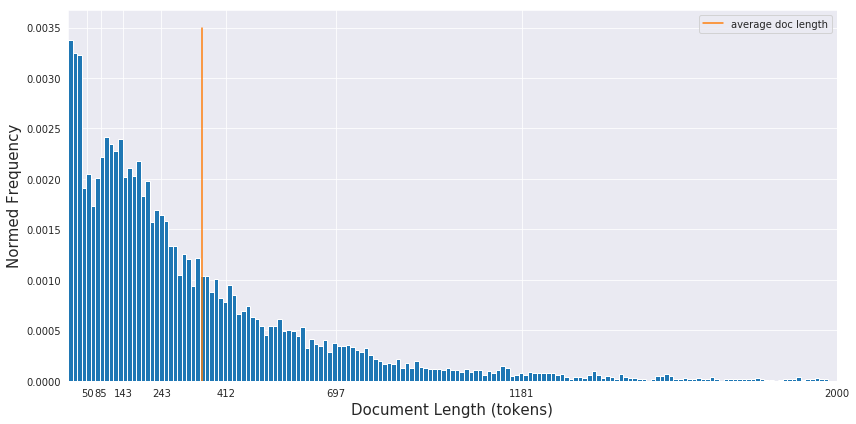

In [0]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [0]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

('After cleaning and excluding short aticles, the dataframe now has:', 10835, 'articles')


In [0]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [0]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [0]:
print(len(df),len(train_df),len(test_df))

(10835, 10822, 13)


In [0]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [0]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python2.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


('Time to train LDA model on ', 10835, 'articles: ', 1.6954107642173768, 'min')


In [0]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(65,
  u'0.056*"devic" + 0.033*"use" + 0.024*"phone" + 0.024*"batteri" + 0.021*"test" + 0.020*"teenag" + 0.016*"call" + 0.016*"mask" + 0.014*"servic" + 0.013*"wear" + 0.013*"walk" + 0.011*"star" + 0.011*"smoke" + 0.011*"code" + 0.009*"onlin" + 0.008*"wire" + 0.008*"can" + 0.008*"fame" + 0.008*"found" + 0.008*"lock"'),
 (50,
  u'0.027*"war" + 0.016*"peopl" + 0.012*"state" + 0.011*"us" + 0.011*"nation" + 0.009*"world" + 0.009*"american" + 0.007*"countri" + 0.006*"power" + 0.006*"peac" + 0.006*"america" + 0.005*"right" + 0.005*"govern" + 0.005*"one" + 0.005*"leader" + 0.005*"unit" + 0.004*"will" + 0.004*"polit" + 0.004*"mani" + 0.004*"militari"'),
 (0,
  u'0.170*"dog" + 0.097*"chicken" + 0.077*"anim" + 0.068*"petit" + 0.049*"pet" + 0.040*"meat" + 0.039*"unwant" + 0.033*"cat" + 0.031*"christma" + 0.029*"festiv" + 0.029*"kenyan" + 0.028*"punch" + 0.027*"kenya" + 0.024*"anniversari" + 0.023*"signatur" + 0.022*"chronicl" + 0.019*"nc" + 0.013*"malik" + 0.012*"amateur" + 0.010*"beaten"'),
 (82

In [0]:
lda.show_topic(topicid=40, topn=20)

[(u'fbi', 0.08191844),
 (u'email', 0.06762746),
 (u'clinton', 0.06617279),
 (u'investig', 0.045266856),
 (u'hillari', 0.041864336),
 (u'comey', 0.033624824),
 (u'server', 0.021987392),
 (u'reopen', 0.018617658),
 (u'new', 0.018184274),
 (u'said', 0.017065931),
 (u'weiner', 0.016832368),
 (u'abedin', 0.015566967),
 (u'huma', 0.014268426),
 (u'friday', 0.011529243),
 (u'anthoni', 0.010781611),
 (u'elect', 0.010011856),
 (u'director', 0.009510633),
 (u'privat', 0.0088113025),
 (u'day', 0.008227241),
 (u'laptop', 0.008114761)]

In [0]:
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

881


In [0]:
print(train_df.iloc[random_article_index,3])

Of course, when you think about it, it was inevitable, says some smart-arsed twat 10-11-16 
THE election of Donald Trump was inevitable and obvious, according to some smug, smart-arsed twat. 
The twat, Martin Bishop, used words including ‘disenfranchised’, ‘swamped’ and ‘angry’ to bolster an argument which was later described as ‘obvious’ and ‘rubbish’. 
Bishop said: “White working class, ignored, globalisation, elite.” 
He added: “Politics of emotion, social media, ignored, globalised, ignored, elites, ignored, ignored, ignored. This doesn’t really affect me.” 
But Professor Henry Brubaker, from the Institute for Studies, said: “It’s because Hillary Clinton was a shit candidate. 
“Are we done?”


In [0]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

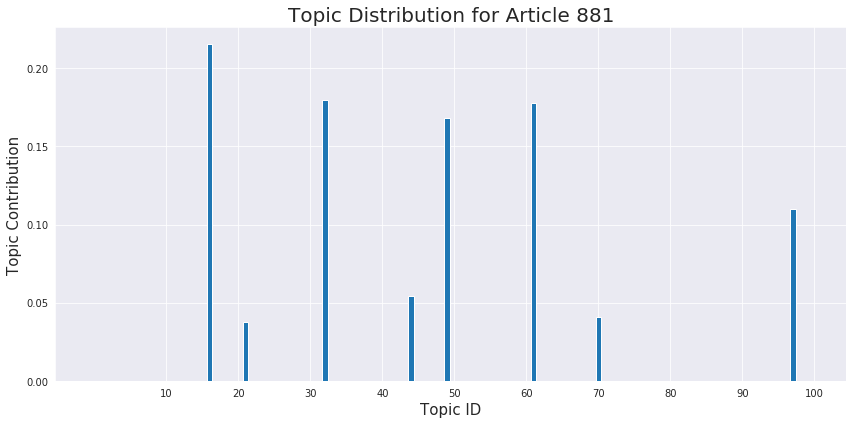

In [0]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.savefig("/content/drive/My Drive/MLAI_Datasets/Document similarity research/seen.png")

In [0]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

(16, [(u'like', 0.016165443), (u'just', 0.015702471), (u'get', 0.01131482), (u'now', 0.0102346605), (u'one', 0.0096493475), (u'peopl', 0.009443871), (u'thing', 0.00832631), (u'watch', 0.008116787), (u'got', 0.0074431235), (u'even', 0.0074233115)], '\n')
(32, [(u'world', 0.026131548), (u'global', 0.01348267), (u'control', 0.012621056), (u'elit', 0.012251966), (u'human', 0.011935216), (u'will', 0.011487786), (u'mani', 0.008481873), (u'peopl', 0.00832548), (u'can', 0.008237773), (u'truth', 0.008063667)], '\n')
(61, [(u'trump', 0.21124241), (u'donald', 0.050858647), (u'elect', 0.01954465), (u'presid', 0.016511153), (u'will', 0.016502175), (u'support', 0.013287626), (u'said', 0.010646141), (u'campaign', 0.009928563), (u'republican', 0.0094451895), (u'say', 0.008032631)], '\n')
(49, [(u'clinton', 0.033717375), (u'hillari', 0.02742839), (u'presid', 0.013340732), (u'parti', 0.011836389), (u'democrat', 0.011687058), (u'polit', 0.011430869), (u'elect', 0.010584089), (u'candid', 0.008637876), (u'

In [0]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)
#random_article_index = 11

5


In [0]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [0]:
print(test_df.iloc[random_article_index,3])

 Why Trump Won and Why Clinton Lost
Hillary Clintons stunning defeat reflected a gross misjudgment by the Democratic Party about the depth of populist anger against self-serving elites who have treated much of the country with disdain
By Robert Parry November 10, 2016 " Information Clearing House " - " Consortium News " - In the end, Hillary Clinton became the face of a corrupt, arrogant and out-of-touch Establishment, while Donald Trump emerged as an almost perfectly imperfect vessel for a populist fury that had bubbled beneath the surface of America.
There is clearly much to fear from a Trump presidency, especially coupled with continued Republican control of Congress. Trump and many Republicans have denied the reality of climate change; they favor more tax cuts for the rich; they want to deregulate Wall Street and other powerful industries  all policies that helped create the current mess that the United States and much of the world are now in.
Further, Trumps personality is prob

In [0]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
#new_doc_distribution = doc_topic_dist[1271]

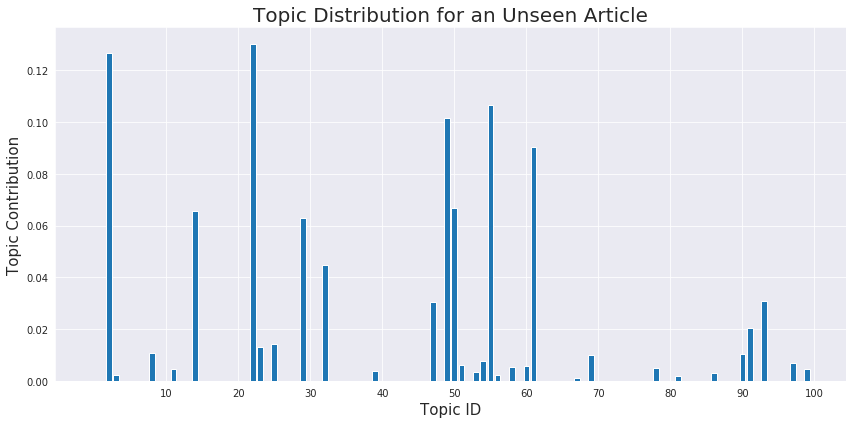

In [0]:
#Let's do the same visual analysis as before on this new unseen document

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.savefig("/content/drive/My Drive/MLAI_Datasets/Document similarity research/unseen.png")

In [0]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

(22, [(u'american', 0.033601776), (u'media', 0.023656972), (u'us', 0.018884545), (u'america', 0.01151536), (u'hillari', 0.009789413), (u'bush', 0.009542136), (u'washington', 0.008221529), (u'establish', 0.007914701), (u'corrupt', 0.007843035), (u'power', 0.0075757606)], '\n')
(2, [(u'polici', 0.011631197), (u'econom', 0.010741309), (u'polit', 0.010288197), (u'corpor', 0.008094699), (u'system', 0.006501416), (u'class', 0.005567315), (u'will', 0.005436389), (u'new', 0.00542367), (u'futur', 0.005022085), (u'progress', 0.0050134785)], '\n')
(55, [(u'syria', 0.06386071), (u'war', 0.048238806), (u'us', 0.037741724), (u'russia', 0.026324186), (u'state', 0.018404432), (u'zone', 0.016777648), (u'militari', 0.015633907), (u'assad', 0.015252479), (u'syrian', 0.015046479), (u'polici', 0.01399969)], '\n')
(49, [(u'clinton', 0.033717375), (u'hillari', 0.02742839), (u'presid', 0.013340732), (u'parti', 0.011836389), (u'democrat', 0.011687058), (u'polit', 0.011430869), (u'elect', 0.010584089), (u'candi

In [0]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(10822, 100)

In [0]:
topics = lda.print_topics(num_topics=100, num_words=10)

In [0]:
M = []
for i in topics:
    tops = i[1].split('+')
    M.append([(float(j.split('*')[0]), j.split('*')[1].strip().strip('"')) for j in tops])

In [0]:
unique_words = set()
for i in M:
    for prob, word in i:
        unique_words.add(word)
unique_words = list(unique_words)

In [0]:
topic_matrix = np.zeros((len(M), len(unique_words)), dtype=np.float64)

In [0]:
for ind, i in enumerate(M):
    for prob, word in i:
        topic_matrix[ind, unique_words.index(word)] = prob

In [0]:
#Word2vec for given docs
w2v_model = Word2Vec(sentences=df.tokenized, workers=4, size=100)

In [0]:
word_sim_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=np.float64)

In [0]:
%%time
metric_space = np.zeros((len(M), len(M)), dtype=np.float64)
for i in xrange(len(M)):
    for j in xrange(len(M)):
        metric_space[i, j] = emd(topic_matrix[i], topic_matrix[j], word_sim_matrix)

In [0]:
for i in xrange(len(unique_words)):
    for j in xrange(len(unique_words)):
        word_sim_matrix[i, j] = cosine(w2v_model[unique_words[i]], w2v_model[unique_words[j]])     

In [0]:
metric_space.shape

In [0]:
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

def emd_query(query, matrix):
    return np.array([emd(query, lst, metric_space) for lst in matrix])

In [0]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    #matrix = matrix.astype(np.float64)
    #query = query.astype(np.float64)
    #sims = emd_query(query, matrix)
    print sims.argsort()[:k]
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [0]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(doc_distribution,doc_topic_dist)
most_sim_ids
print train_df.loc[1058, "text"]

In [0]:
similar_bow = dictionary.doc2bow(train_df.iloc[1058,7])
similar_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=similar_bow)])
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(similar_distribution)), similar_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Similar Article (with Jenson Shannon)", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
#plt.show()
plt.savefig("/Users/ankushbhatia/personal/seen_similar2.png")

In [0]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
for title in most_similar_df.text.tolist():
    print title
    print "#"*100

In [0]:
fig, ax = plt.subplots(figsize=(12,6));
patches = ax.bar(np.arange(len(new_doc_distribution)), doc_topic_dist[289])
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

# DOC2VEC Training

In [0]:
from gensim.models import doc2vec
from collections import namedtuple

In [0]:
tagged_docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')

In [0]:
for ind, tokens in enumerate(train_df['tokenized'].tolist()):
    tags = [ind]
    tagged_docs.append(analyzedDocument(tokens, tags))

In [0]:
%%time
model = doc2vec.Doc2Vec(tagged_docs, size = 100, window = 300, workers = 4)

In [0]:
model.docvecs.most_similar(8127)

In [0]:
print train_df.iloc[6434, 3]

In [0]:
df['new_check'] = df.uuid.copy()

In [0]:
train_df.index